In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np

# 定义自己想用的网络
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 2维卷积 参数： 输入通道数， 输出通道数， 卷积核大小， 步长， 边界填0数
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # relu 激活函数
        self.relu1 = nn.ReLU(inplace=True)
        # 最大池化 参数：池化核大小， 步长
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten1 = nn.Flatten(start_dim=1, end_dim=-1)
        # 全连接层 参数： 输入特征长度， 输出特征长度
        self.linear1 = torch.nn.Linear(in_features=16*7*7, out_features=120)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = torch.nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU(inplace=True)
        self.linear3 = torch.nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        # 将数据的shape从 B C H W -> B C HW  
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        y = self.linear3(x)
        return y

# 设置超参数
num_epochs = 10
learning_rate = 0.001
epsilon = 0.5

# 学习率衰减系数
weight_decay = 5e-4
# 训练集的batchsize
batch_size_train = 64
# 测试集的batchsize
batch_size_test = 64

save_dir = './ckp/MNIST/Adam1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists('./log/MNIST/'):
    os.makedirs('./log/MNIST/')
writer = SummaryWriter(logdir= 'log/MNIST/Adam')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 构造训练数据集trian_loader(dataset->dataloader)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
# 构造测试数据集test_loader(dataset->dataloader)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

model = AlexNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

d:\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'D:\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


AlexNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=120, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


tag: 4


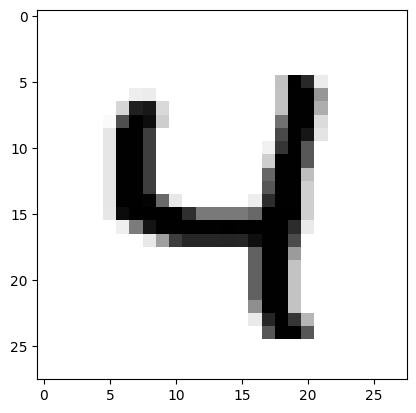

torch.Size([28, 28, 1])


In [2]:
# 加载模型
model_dict = torch.load('model.pth') 
# 可以加载经过对抗训练后的模型
# model_dict = torch.load('adv_model.pth') 
model.load_state_dict(model_dict)
# 模型设置为测试模式
model.eval() 
test_sums = []

for batch_id, data in enumerate(test_loader):
    # 获取数据
    x_data = data[0]
    y_data = data[1]
    # 模型的前向计算
    outs = model(x_data)
    # print(outs.shape)
    # 获取预测结果
    preds = torch.argmax(outs, dim = 1)
    sums = torch.sum(preds == y_data)
    test_sums.append(sums)
        
# 添加验证集的图像
# 和前面eval一样
tag = preds[0].detach().numpy()
print('tag:', tag)
# 由于图像是B C H W，只要batch的第一个
img = x_data[0,:,:,:]
# 将C H W-> H  W  C
img = img.permute(1,2,0)
# 图像显示
plt.figure()
plt.imshow(img[:,:,0], cmap=plt.cm.binary)  #图片大小为 [32,32]
plt.show()
print(img.shape)

In [3]:
# FGSM和PGD攻击
loss_fn = nn.CrossEntropyLoss()

class Attack():
    def fgsm(self,image,label):
        image.requires_grad = True
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        image_adv = image + epsilon * image.grad.sign()
        image_adv = torch.clamp(image_adv, 0, 1)

        return image_adv

    def PGD(self,image,label):

        images = image.clone().detach().to(device)
        labels = label.clone().detach().to(device)

        adv_images = images.clone().detach()

        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(10): #迭代进行攻击
            adv_images.requires_grad = True
            outputs = model(adv_images)

            cost = loss_fn(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + epsilon*grad.sign()
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

atk = Attack()

In [4]:
def eval(model, test_dataloader, attack_model=None):
    val_sums = []
    # 将模型设置为验证模式，这样就不会计算梯度
    model.eval()
    dataloader = tqdm(test_dataloader)
    dataloader.set_description('val')
    # 获取dataloader的数据
    for batch_id, data in enumerate(dataloader):
        # 获取第一个数据，即图像的tensor
        x_data = data[0]
        # 获取第二个数据，即图像的类别tensor
        y_data = data[1]
        if attack_model!=None:
            #生成对抗样本
            x_data = attack_model.fgsm(x_data, y_data)
        # 将图像放入模型前向计算，并获取预测结果
        outs = model(x_data)
        
        # 获取预测结果的分类类别
        preds = torch.argmax(outs, dim = 1)
        # 计算预测准确的数量
        sums = torch.sum(preds == y_data)
        # 把每个batch的预测准确数量加入到数组中，便于后续计算acc
        val_sums.append(sums)
        
    # 计算acc，数组里预测准确数量总和除以数据总量
    val_acc = sum(val_sums)/len(test_dataloader.dataset)
    print("batch_id: {}, Accuracy of the model is: {:.4f}".format(batch_id,  val_acc.detach().numpy()))
    return val_acc

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_dir = './ckp/MNIST/Adam1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists('./log/MNIST/'):
    os.makedirs('./log/MNIST/')
writer = SummaryWriter(logdir= 'log/MNIST/Adam')

In [5]:
losses = [] #用于保存训练过程中的 loss 值
acces = []
attack_acces = []

def attack_train(model, total_epochs, train_dataloader, test_dataloader, attack_model=None):
    model.train()
    best_acc = 0.0
    firststep = 0
    for epoch in range(total_epochs):
        dataloader = tqdm(train_dataloader)
        dataloader.set_description('epoch: {}/{}'.format(epoch + 1, total_epochs))
        temp_loss = 0
        for i, data in enumerate(dataloader):
            # 前向传播
            x_data = data[0]
            y_data = data[1]

            X, y = x_data.to(device), y_data.to(device)
            if attack_model!=None:
                #生成对抗样本
                X_adv = attack_model.fgsm(X, y)
                #合并样本
                X = torch.cat((X, X_adv), dim=0)
                y = torch.cat((y, y), dim=0)

            outs = model(X)
            acc = 0
            loss = F.cross_entropy(outs, y)
            # 计算每个batch的loss平均值
            avg_loss = torch.mean(loss)
            temp_loss = avg_loss
            
            # 获取预测的标签
            preds = torch.argmax(outs, dim = 1)
            # 计算每个batchsize的acc
            acc = torch.sum(preds == y)/preds.shape[0]

            # 反向传播和优化
            avg_loss.backward()
            optimizer.step()
            if firststep==0:
                firststep=1
                tip = 0
                for parms in model.parameters():
                    tip += 1
                    if tip ==1:
                        filter1 = parms.grad
                    if tip ==3: #只有conv层可以可视化，maxpooling层和relu层不能可视化
                        filter3 = parms.grad
                
                torch.save({"conv1":filter1, "conv2":filter3},"./grad")

            optimizer.zero_grad()

            dataloader.set_postfix(loss='{:.4f}'.format(loss.detach().numpy()), acc='{:.4f}'.format(acc.detach().numpy()))
                
        # 保存每轮epoch的模型
        save_model_dir = save_dir +"/model{}".format(epoch+1)+".pth"
        # 保存的模型
        torch.save(model.state_dict(),save_model_dir )
        print("model is saved in: "+str(save_model_dir))

        # eval方法
        val_acc = eval(model, test_dataloader)
        if val_acc > best_acc:
            # 保存最佳模型
            save_model_dir = save_dir +"/best_model"+".pth"
            # 保存模型
            torch.save(model.state_dict(), save_model_dir )
            print("best_model is saved in: "+str(save_model_dir))
            best_acc = val_acc
            print("best_acc: "+str(best_acc.detach().numpy()))
        losses.append(temp_loss.detach().numpy())
        acces.append(val_acc.detach().numpy())
        attack_acc = eval(model, test_dataloader, Attack())
        attack_acces.append(attack_acc.detach().numpy())

In [20]:
# 对抗训练前的模型评估
accuracy_before = eval(model, test_loader)
print(f'Accuracy before adversarial training: {accuracy_before:.2%}')

accuracy_before_adv = eval(model, test_loader, Attack())
print(f'Accuracy before adversarial training (with adversarial examples): {accuracy_before_adv:.2%}')

attack_train(model, num_epochs, train_loader, test_loader, Attack())
# 其中包含每轮对抗训练后的模型评估
# 可以存储对抗训练后的模型
# torch.save(model.state_dict(), 'adv_model.pth')

val: 100%|██████████| 157/157 [00:02<00:00, 70.77it/s]


batch_id: 156, Accuracy of the model is: 0.9901
Accuracy before adversarial training: 99.01%


val: 100%|██████████| 157/157 [00:03<00:00, 44.61it/s]


batch_id: 156, Accuracy of the model is: 0.8714
Accuracy before adversarial training (with adversarial examples): 87.14%


epoch: 1/10: 100%|██████████| 938/938 [00:37<00:00, 25.07it/s, acc=0.9531, loss=0.2472]


model is saved in: ./ckp/MNIST/Adam1/model1.pth


val: 100%|██████████| 157/157 [00:02<00:00, 70.39it/s]


batch_id: 156, Accuracy of the model is: 0.9926
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9926


val: 100%|██████████| 157/157 [00:03<00:00, 43.69it/s]


batch_id: 156, Accuracy of the model is: 0.9441


epoch: 2/10: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s, acc=0.9844, loss=0.0349]


model is saved in: ./ckp/MNIST/Adam1/model2.pth


val: 100%|██████████| 157/157 [00:02<00:00, 71.41it/s]


batch_id: 156, Accuracy of the model is: 0.9931
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9931


val: 100%|██████████| 157/157 [00:03<00:00, 43.51it/s]


batch_id: 156, Accuracy of the model is: 0.9503


epoch: 3/10: 100%|██████████| 938/938 [00:37<00:00, 24.99it/s, acc=1.0000, loss=0.0179]


model is saved in: ./ckp/MNIST/Adam1/model3.pth


val: 100%|██████████| 157/157 [00:02<00:00, 73.44it/s]


batch_id: 156, Accuracy of the model is: 0.9962
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9962


val: 100%|██████████| 157/157 [00:03<00:00, 43.83it/s]


batch_id: 156, Accuracy of the model is: 0.9600


epoch: 4/10: 100%|██████████| 938/938 [00:38<00:00, 24.63it/s, acc=0.9688, loss=0.0530]


model is saved in: ./ckp/MNIST/Adam1/model4.pth


val: 100%|██████████| 157/157 [00:02<00:00, 70.10it/s]


batch_id: 156, Accuracy of the model is: 0.9968
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9968


val: 100%|██████████| 157/157 [00:03<00:00, 41.50it/s]


batch_id: 156, Accuracy of the model is: 0.9599


epoch: 5/10: 100%|██████████| 938/938 [00:37<00:00, 25.06it/s, acc=0.9844, loss=0.0378]


model is saved in: ./ckp/MNIST/Adam1/model5.pth


val: 100%|██████████| 157/157 [00:02<00:00, 73.26it/s]


batch_id: 156, Accuracy of the model is: 0.9966


val: 100%|██████████| 157/157 [00:03<00:00, 44.33it/s]


batch_id: 156, Accuracy of the model is: 0.9563


epoch: 6/10: 100%|██████████| 938/938 [00:36<00:00, 25.63it/s, acc=1.0000, loss=0.0008]


model is saved in: ./ckp/MNIST/Adam1/model6.pth


val: 100%|██████████| 157/157 [00:02<00:00, 72.94it/s]


batch_id: 156, Accuracy of the model is: 0.9970
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.997


val: 100%|██████████| 157/157 [00:03<00:00, 44.17it/s]


batch_id: 156, Accuracy of the model is: 0.9678


epoch: 7/10: 100%|██████████| 938/938 [00:36<00:00, 25.45it/s, acc=0.9688, loss=0.0572]


model is saved in: ./ckp/MNIST/Adam1/model7.pth


val: 100%|██████████| 157/157 [00:02<00:00, 72.86it/s]


batch_id: 156, Accuracy of the model is: 0.9986
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9986


val: 100%|██████████| 157/157 [00:03<00:00, 43.90it/s]


batch_id: 156, Accuracy of the model is: 0.9685


epoch: 8/10: 100%|██████████| 938/938 [00:37<00:00, 25.20it/s, acc=1.0000, loss=0.0082]


model is saved in: ./ckp/MNIST/Adam1/model8.pth


val: 100%|██████████| 157/157 [00:02<00:00, 71.73it/s]


batch_id: 156, Accuracy of the model is: 0.9974


val: 100%|██████████| 157/157 [00:03<00:00, 43.23it/s]


batch_id: 156, Accuracy of the model is: 0.9715


epoch: 9/10: 100%|██████████| 938/938 [00:38<00:00, 24.11it/s, acc=0.9531, loss=0.1528]


model is saved in: ./ckp/MNIST/Adam1/model9.pth


val: 100%|██████████| 157/157 [00:02<00:00, 57.74it/s]


batch_id: 156, Accuracy of the model is: 0.9971


val: 100%|██████████| 157/157 [00:06<00:00, 25.09it/s]


batch_id: 156, Accuracy of the model is: 0.9698


epoch: 10/10: 100%|██████████| 938/938 [00:40<00:00, 23.37it/s, acc=0.9844, loss=0.0194]


model is saved in: ./ckp/MNIST/Adam1/model10.pth


val: 100%|██████████| 157/157 [00:02<00:00, 74.13it/s]


batch_id: 156, Accuracy of the model is: 0.9991
best_model is saved in: ./ckp/MNIST/Adam1/best_model.pth
best_acc: 0.9991


val: 100%|██████████| 157/157 [00:03<00:00, 43.29it/s]

batch_id: 156, Accuracy of the model is: 0.9745


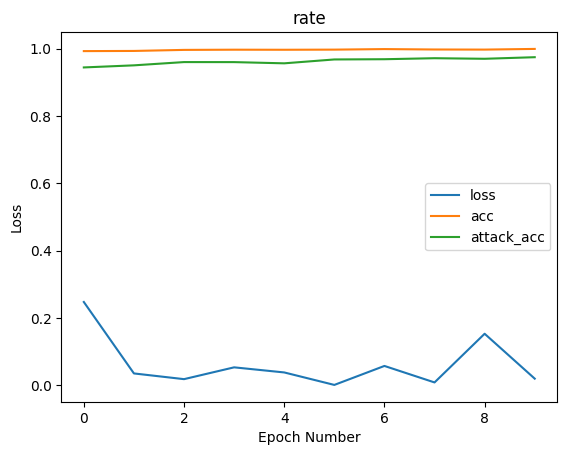

In [22]:
# 绘制变化图
plt.plot(losses)
plt.plot(acces)
plt.plot(attack_acces)
plt.legend(["loss", "acc", "attack_acc"])
plt.title('rate')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

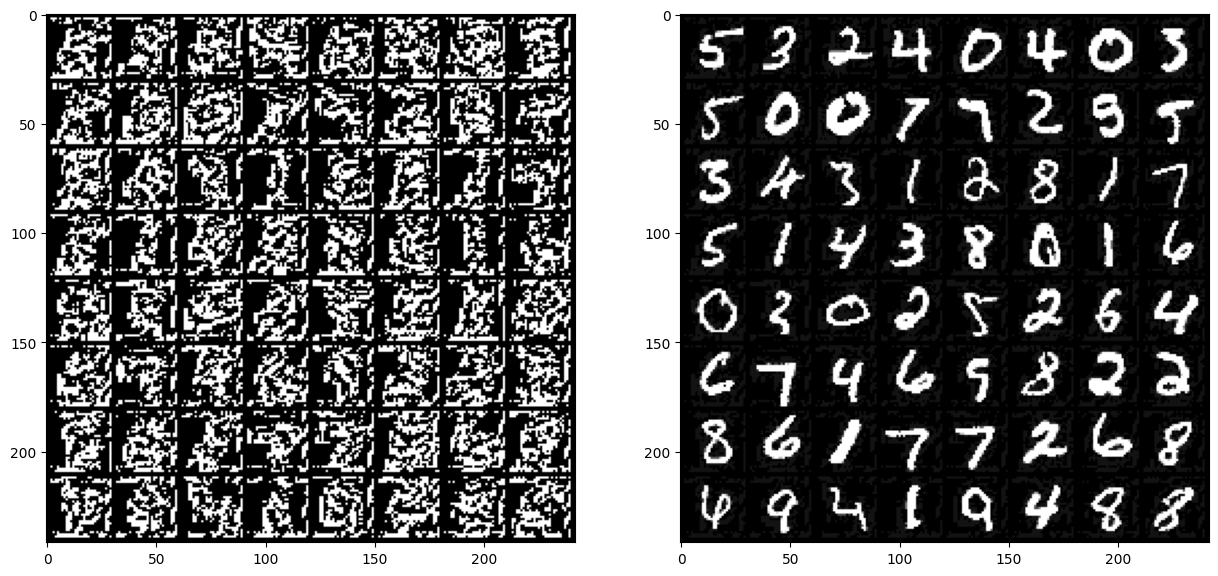

In [8]:
# FGSM可视化
for image, label in test_loader:
    image.requires_grad = True
    output = model(image)
    loss = loss_fn(output, label)
    loss.backward()
    plt.figure(figsize=(15, 8))

    plt.subplot(121)
    image_grid = torchvision.utils.make_grid(torch.clamp(image.grad.sign(), 0, 1))
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))
    # 可视化对抗干扰
        
    image_adv = image + epsilon * image.grad.sign()
    image_adv = torch.clamp(image_adv, 0, 1)

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(image_adv)
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))
    # 可视化对抗样本

    break

防御失败样本可视化

 10%|█         | 16/157 [00:00<00:03, 36.47it/s]


Accuracy of the model on attack: 97.36328125 %
Accuracy of the initial model: 99.90234375 %
Accuracy of the attack: 2.541544477028348 %
997
1024
1023


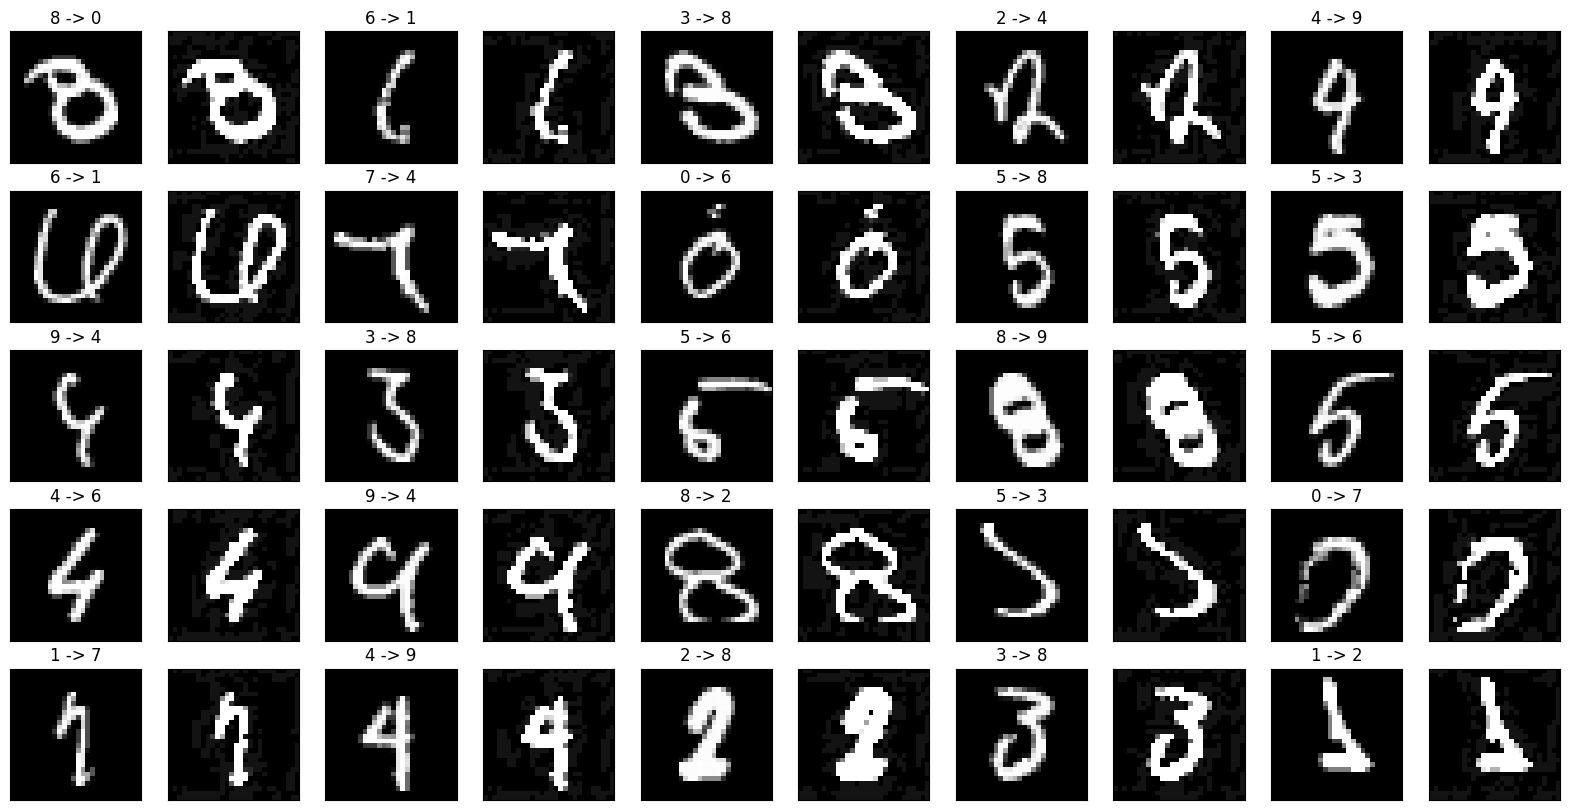

In [6]:
def fgsm_run():
    # 运行FGSM算法
    model.eval()
    correct = 0
    total = 0
    init_correct = 0
    atk = Attack()

    adver_nums = 1000
    batch_size = 64
    i = 0
    # 这几个变量主要用于之后的测试以及可视化
    adver_example_by_fgsm = torch.zeros((batch_size, 1, 28, 28)).to(device)
    adver_target = torch.zeros(batch_size).to(device)
    clean_example = torch.zeros((batch_size, 1, 28, 28)).to(device)
    clean_target = torch.zeros(batch_size).to(device)
    real_label = torch.zeros(batch_size).to(device)
    for image, label in tqdm(test_loader):
        if i >= adver_nums / batch_size:
            break

        init_outputs = model(image)
        _, init_predicted = torch.max(init_outputs.data, 1)
        image = image.to(device)
        label = label.to(device)
        image_adv = atk.fgsm(image, label)

        outputs = model(image_adv)
        # 使用对抗样本攻击VGG模型
        _, predicted = torch.max(outputs.data, 1)
        if i == 0:
            clean_example = image
            adver_example_by_fgsm = image_adv
            clean_target = label
            adver_target = predicted
            real_label = label
        else:
            clean_example = torch.cat((clean_example, image), dim=0)
            adver_example_by_fgsm = torch.cat((adver_example_by_fgsm, image_adv), dim=0)
            clean_target = torch.cat((clean_target, init_predicted), dim=0)
            adver_target = torch.cat((adver_target, predicted), dim=0)
            real_label = torch.cat((real_label, label), dim=0)
        total += label.size(0)
        init_correct_squ = init_predicted == label
        correct_squ = predicted == label
        correct += (correct_squ & init_correct_squ).sum().item()
        init_correct += init_correct_squ.sum().item()
        i += 1

    print(f'Accuracy of the model on attack: {100 * correct / total} %')
    print(f'Accuracy of the initial model: {100 * init_correct / total} %')
    print(f'Accuracy of the attack: {100 * (init_correct - correct) / init_correct} %')
    print(correct)
    print(total)
    print(init_correct)
    return adver_example_by_fgsm, adver_target, clean_example, clean_target, real_label

def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,real_label):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      #添加筛选条件
      while clean_target[cnt] != real_label[cnt]: #干净样本预测成功
        cnt+=1
      while adver_target[cnt] == clean_target[cnt]: #对抗样本预测失败
        cnt+=1
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()

adver_example_by_fgsm, adver_target, clean_example, clean_target, real_label = fgsm_run()
plot_clean_and_adver(adver_example_by_fgsm,adver_target,clean_example,clean_target,real_label)